# TensorFlow for tabular data (with categorical variables)

This notebook applies TensorFlow / Keras tecniques for tabular data as described in:

* https://github.com/lmassaron/deep_learning_for_tabular_data
* https://www.kaggle.com/lucamassaron/deep-learning-for-tabular-data

and as presented at various meetups and Google DevFests:
* https://www.youtube.com/watch?v=nQgUt_uADSE

In particular, in the code you will find different data pipelines drafted for binary, high cardinality nominal, low cardinality nominal, ordinal, dates.

The code is fully commented for you to explore and experiment, and, more important, it will be regularly updated during the competition with furthermore feature creation and more performing neural architectures.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/cat-in-the-dat-ii/train.csv
/kaggle/input/cat-in-the-dat-ii/test.csv
/kaggle/input/cat-in-the-dat-ii/sample_submission.csv


In [2]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

# Data transformation pipelines
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# TensorFlow 
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, Nadam
from keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from keras.layers import Activation, LeakyReLU
from keras.optimizers import SGD, Adam, Nadam
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2, l1_l2
from keras.losses import binary_crossentropy
from keras.utils import get_custom_objects
from keras.layers import Activation, LeakyReLU
from keras.models import load_model

Using TensorFlow backend.


In [4]:
# Reading the data
X = pd.read_csv("/kaggle/input/cat-in-the-dat-ii/train.csv")
Xt = pd.read_csv("/kaggle/input/cat-in-the-dat-ii/test.csv")

In [5]:
# Separating target and ids
y = X.target.values
id_train = X.id
id_test = Xt.id

X.drop(['id', 'target'], axis=1, inplace=True)
Xt.drop(['id'], axis=1, inplace=True)

In [6]:
# Classifying variables in binary, high and low cardinality nominal, ordinal and dates
binary_vars = [c for c in X.columns if 'bin_' in c]

nominal_vars = [c for c in X.columns if 'nom_' in c]
high_cardinality = [c for c in nominal_vars if len(X[c].unique()) > 16]
low_cardinality = [c for c in nominal_vars if len(X[c].unique()) <= 16]

ordinal_vars = [c for c in X.columns if 'ord_' in c]

time_vars = ['day', 'month']

In [7]:
# Some feature engineering
X['ord_5_1'] = X['ord_5'].apply(lambda x: x[0] if type(x) == str else np.nan)
X['ord_5_2'] = X['ord_5'].apply(lambda x: x[1] if type(x) == str else np.nan)
Xt['ord_5_1'] = Xt['ord_5'].apply(lambda x: x[0] if type(x) == str else np.nan)
Xt['ord_5_2'] = Xt['ord_5'].apply(lambda x: x[1] if type(x) == str else np.nan)

ordinal_vars += ['ord_5_1', 'ord_5_2']

In [8]:
# Converting ordinal labels into ordered values
ordinals = {
    'ord_1' : {
        'Novice' : 0,
        'Contributor' : 1,
        'Expert' : 2,
        'Master' : 3,
        'Grandmaster' : 4
    },
    'ord_2' : {
        'Freezing' : 0,
        'Cold' : 1,
        'Warm' : 2,
        'Hot' : 3,
        'Boiling Hot' : 4,
        'Lava Hot' : 5
    }
}

def return_order(X, Xt, var_name):
    mode = X[var_name].mode()[0]
    el = sorted(set(X[var_name].fillna(mode).unique())|set(Xt[var_name].fillna(mode).unique()))
    return {v:e for e, v in enumerate(el)}

for mapped_var in ordinal_vars:
    if mapped_var not in ordinals:
        mapped_values = return_order(X, Xt, mapped_var)
        X[mapped_var].replace(mapped_values, inplace=True)
        Xt[mapped_var].replace(mapped_values, inplace=True)
    else:
        X[mapped_var].replace(ordinals[mapped_var], inplace=True)
        Xt[mapped_var].replace(ordinals[mapped_var], inplace=True)

In [9]:
# Creating a list of numpy values from high cardinality variables
X_cat, Xt_cat = list(), list()
categorical_counts = dict()

for hc in binary_vars+nominal_vars+ordinal_vars+time_vars:
    # Finding out the levels in each high cardinality variable
    levels = set(X[hc].astype(str).fillna("NAN").unique())|set(Xt[hc].astype(str).fillna("NAN").unique())
    levels = np.array(list(levels))
    # Counting the levels
    categorical_counts[hc] = len(levels)
    # Converting the levels into numeric values
    le = LabelEncoder()
    le.fit(np.ravel(levels.reshape(-1,1)))
    X_cat.append(le.transform(X[hc].astype(str).fillna("NAN").values))
    Xt_cat.append(le.transform(Xt[hc].astype(str).fillna("NAN").values))

print("Countings for high cardinality variables:")
print(categorical_counts)

Countings for high cardinality variables:
{'bin_0': 3, 'bin_1': 3, 'bin_2': 3, 'bin_3': 3, 'bin_4': 3, 'nom_0': 4, 'nom_1': 7, 'nom_2': 7, 'nom_3': 7, 'nom_4': 5, 'nom_5': 1221, 'nom_6': 1521, 'nom_7': 223, 'nom_8': 223, 'nom_9': 2219, 'ord_0': 4, 'ord_1': 6, 'ord_2': 7, 'ord_3': 16, 'ord_4': 27, 'ord_5': 191, 'ord_5_1': 52, 'ord_5_2': 51, 'day': 8, 'month': 13}


In [10]:
# Enconding frequencies instead of labels (so we have some numeric variables)

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

freq_encoded = list()

for column in X.columns:
    train_values, test_values = frequency_encoding(column, X, Xt)
    X[column+'_counts'] = train_values
    Xt[column+'_counts'] = test_values
    freq_encoded.append(column+'_counts')

In [11]:
# Target encoding of selected variables
import category_encoders as cat_encs

cat_feat_to_encode = binary_vars + ordinal_vars + nominal_vars + time_vars
smoothing = 0.3

enc_x = np.zeros(X[cat_feat_to_encode].shape)

for tr_idx, oof_idx in StratifiedKFold(n_splits=3, random_state=42, shuffle=True).split(X, y):
    encoder = cat_encs.TargetEncoder(cols=cat_feat_to_encode, smoothing=smoothing)
    
    encoder.fit(X[cat_feat_to_encode].iloc[tr_idx], y[tr_idx])
    enc_x[oof_idx, :] = encoder.transform(X[cat_feat_to_encode].iloc[oof_idx], y[oof_idx])
    
encoder.fit(X[cat_feat_to_encode], y)
enc_xt = encoder.transform(Xt[cat_feat_to_encode]).values

target_encoded = list()

for idx, new_var in enumerate(cat_feat_to_encode):
    new_var = new_var + '_enc'
    X[new_var] = enc_x[:,idx]
    Xt[new_var] = enc_xt[:, idx]
    target_encoded.append(new_var)

In [12]:
# The values are normalized using the Standard Scaler
ssc = StandardScaler()
selection = freq_encoded + target_encoded + ordinal_vars + time_vars
X_ohe = ssc.fit_transform(X[selection].fillna(X[selection].median()))
Xt_ohe = ssc.transform(Xt[selection].fillna(X[selection].median()))

In [13]:
# Adding the GELU and LEAKY RELU functions as custom objects 
# (see: https://datascience.stackexchange.com/questions/49522/what-is-gelu-activation)

def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})

# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

/opt/conda/lib/python3.6/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [14]:
# Parametric DNN architecture

def tabular_dnn(numeric_variables, categorical_variables, categorical_counts,
                feature_selection_dropout=0.2, categorical_dropout=0.1,
                first_dense = 256, second_dense = 256, dense_dropout = 0.2, 
                activation_type=gelu):
    
    # Numeric inputs pipeline
    numerical_inputs = Input(shape=(numeric_variables,))
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(feature_selection_dropout)(numerical_normalization)

    # Categorical inputs pipeline
    categorical_inputs = []
    categorical_embeddings = []
    for category in categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      min(int(category_counts/1.5 + 1), 3), 
                      name = category + "_embed")(categorical_inputs[-1]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(categorical_dropout)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])

    # Fully connected layers
    x = concatenate([numerical_feature_selection, categorical_logits])
    x = BatchNormalization()(x)
    
    x = Dense(first_dense, activation=activation_type)(x)
    x = BatchNormalization()(x)
    x = Dropout(dense_dropout)(x)
    
    x = Dense(second_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)
    x = BatchNormalization()(x)
    
    # Sigmoid final activation
    output = Dense(1, activation="sigmoid")(x)
    
    # Composing the model -> input list of numeric and each high cardinality variable
    model = Model([numerical_inputs] + categorical_inputs, output)
    
    return model

In [15]:
# Useful functions for training DNNs

def auroc(y_true, y_pred):
    try:
        return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    except:
        return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

get_custom_objects().update({'auroc': auroc})  

def mAP(y_true, y_pred):
    try:
        return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)
    except:
        return tf.py_func(average_precision_score, (y_true, y_pred), tf.double)
    
get_custom_objects().update({'mAP': mAP})

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [16]:
# train/validation batch generator
def batch_generator(X_ohe, X_cat, y, cv=5, batch_size=64, random_state=None):
    '''
    Returns a batch from X, y
    random_state allows determinism
    different scikit-learn CV strategies are possible
    '''
    folds = len(y) // batch_size
    if isinstance(cv, int):
        kf = StratifiedKFold(n_splits=cv, 
                              shuffle=True, 
                              random_state=random_state)
    else:
        kf = cv
    
    while True:
        for _, batch_index in kf.split(X_ohe, y):
            numeric_input = X_ohe[batch_index].astype(np.float32)
            categorical_input = [X_cat[i][batch_index] for i in range(len(X_cat))]
            target = y[batch_index]
            yield [numeric_input] + categorical_input, target

In [17]:
# Global training settings
SEED = 42
FOLDS = 20
MAX_EPOCHS = 100
BATCH_SIZE = 1024 * 4

In [18]:
# Defining callbacks
measure_to_monitor = 'val_auroc' 
modality = 'max'

early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                               mode=modality, 
                               patience=5, 
                               verbose=0)

model_checkpoint = ModelCheckpoint('best.model', 
                                   monitor=measure_to_monitor, 
                                   mode=modality, 
                                   save_best_only=True, 
                                   verbose=0)

model_reduce_lr = ReduceLROnPlateau(monitor=measure_to_monitor,
                                    mode=modality,
                                    factor=0.25,
                                    patience=2, 
                                    min_lr=1e-6, 
                                    verbose=1)

In [19]:
# Defining model
model_params = {
    "numeric_variables" : X_ohe.shape[1], 
    "categorical_variables" : categorical_counts.keys(),
    "categorical_counts" : categorical_counts, 
    "feature_selection_dropout" : 0.0,
    "categorical_dropout" : 0.3,
    "first_dense" : 512,
    "second_dense" : 512,
    "dense_dropout" : 0.3,
    "activation_type" : 'relu'
}

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 36s 259ms/step - loss: 0.7024 - auroc: 0.6690 - mAP: 0.3274 - val_loss: 0.6180 - val_auroc: 0.7662 - val_mAP: 0.4428
Epoch 2/100
139/139 [==============================] - 32s 232ms/step - loss: 0.5846 - auroc: 0.6984 - mAP: 0.3727 - val_loss: 0.5202 - val_auroc: 0.7698 - val_mAP: 0.4513
Epoch 3/100
139/139 [==============================] - 32s 228ms/step - loss: 0.5170 - auroc: 0.7100 - mAP: 0.3836 - val_loss: 0.4589 - val_auroc: 0.7757 - val_mAP: 0.4539
Epoch 4/100
139/139 [==============================] - 32s 231ms/step - loss: 0.4713 - auroc: 0.7239 - mAP: 0.3923 - val_loss: 0.4262 - val_auroc: 0.7764 - val_mAP: 0.4513
Epoch 5/100
139/139 [==============================] - 32s 233ms/step - loss: 0.4419 - auroc: 0.7417 - mAP: 0.4049 - val_loss: 0.4093 - val_auroc: 0.7787 - val_mAP: 0.4559
Epoch 6/100
139/139 [==============================] - 31s 226ms/step - loss: 0.4237 - auroc: 0.7586 - mAP: 0.4201 - val_loss: 0.4063 - val_

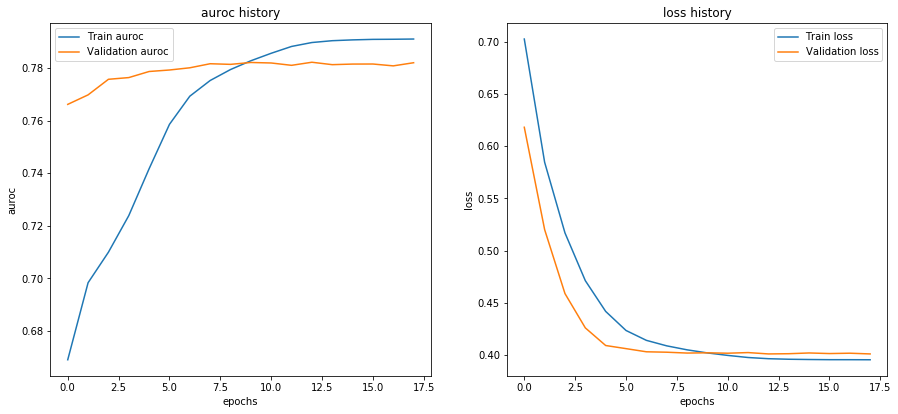

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 12us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 36s 256ms/step - loss: 0.6970 - auroc: 0.6706 - mAP: 0.3298 - val_loss: 0.4991 - val_auroc: 0.7693 - val_mAP: 0.4514
Epoch 2/100
139/139 [==============================] - 32s 233ms/step - loss: 0.5839 - auroc: 0.7002 - mAP: 0.3763 - val_loss: 0.4598 - val_auroc: 0.7761 - val_mAP: 0.4619
Epoch 3/100
139/139 [==============================] - 32s 231ms/step - loss: 0.5172 - auroc: 0.7103 - mAP: 0.3857 - val_loss: 0.4409 - val_auroc: 0.7785 - val_mAP: 0.4590
Epoch 4/100
139/139 [==============================] - 33s 238ms/step - loss: 0.4725 - auroc: 0.7222 - mAP: 0.3930 - val_loss: 0.4091 - val_auroc: 0.7812 - val_mAP: 0.4628
Epoch 5/100
139/139 [==============================] - 33s 240ms/step - loss: 0.4451 - auroc: 0.7372 - mAP: 0.4048 - val_loss: 0.3963 - val_auroc: 0.7837 - val_mAP: 0.4639
Epoch 6/100
139/139 [==============================] - 33s 235ms/step - loss: 0.4269 - auroc: 0.7525 - mAP: 0.4206 - val_loss: 0.4020 - val_

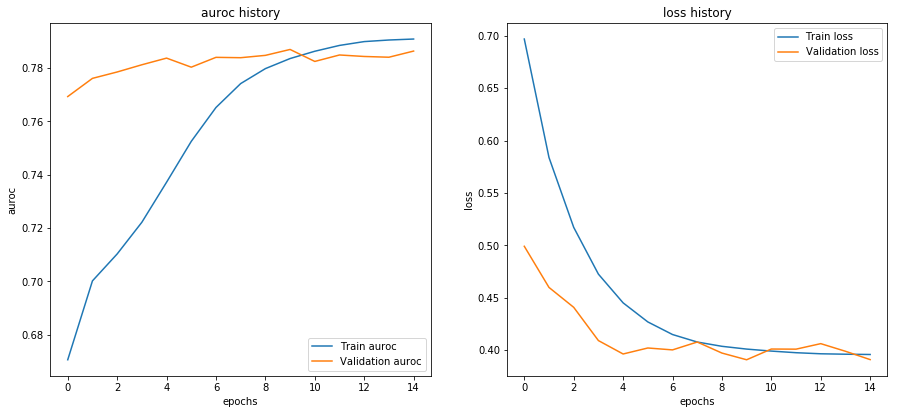

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 12us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 37s 266ms/step - loss: 0.7023 - auroc: 0.6695 - mAP: 0.3286 - val_loss: 0.5716 - val_auroc: 0.7688 - val_mAP: 0.4457
Epoch 2/100
139/139 [==============================] - 33s 234ms/step - loss: 0.5843 - auroc: 0.6980 - mAP: 0.3723 - val_loss: 0.4942 - val_auroc: 0.7753 - val_mAP: 0.4545
Epoch 3/100
139/139 [==============================] - 33s 235ms/step - loss: 0.5163 - auroc: 0.7095 - mAP: 0.3834 - val_loss: 0.4523 - val_auroc: 0.7755 - val_mAP: 0.4556
Epoch 4/100
139/139 [==============================] - 33s 235ms/step - loss: 0.4711 - auroc: 0.7231 - mAP: 0.3924 - val_loss: 0.4140 - val_auroc: 0.7830 - val_mAP: 0.4583
Epoch 5/100
139/139 [==============================] - 32s 231ms/step - loss: 0.4427 - auroc: 0.7402 - mAP: 0.4044 - val_loss: 0.4076 - val_auroc: 0.7821 - val_mAP: 0.4590
Epoch 6/100
139/139 [==============================] - 33s 235ms/step - loss: 0.4244 - auroc: 0.7571 - mAP: 0.4196 - val_loss: 0.3994 - val_

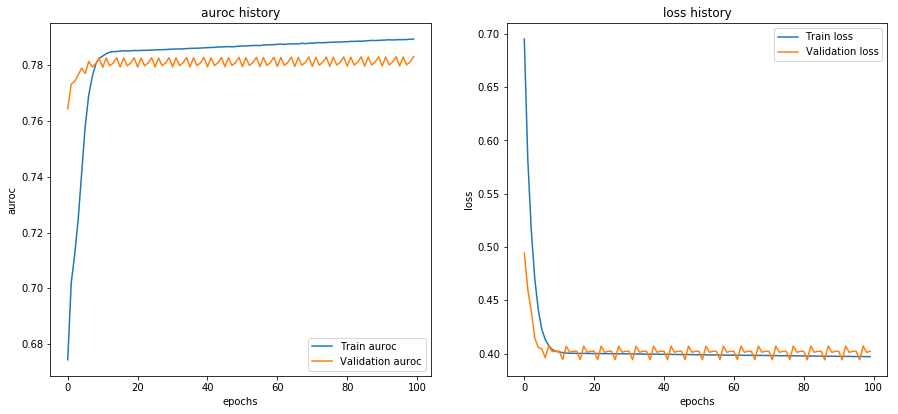

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 12us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 32s 230ms/step - loss: 0.4011 - auroc: 0.7835 - mAP: 0.4606 - val_loss: 0.3981 - val_auroc: 0.7857 - val_mAP: 0.4672
Epoch 14/100
139/139 [==============================] - 32s 227ms/step - loss: 0.4010 - auroc: 0.7835 - mAP: 0.4606 - val_loss: 0.3868 - val_auroc: 0.7869 - val_mAP: 0.4729

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 15/100
139/139 [==============================] - 32s 229ms/step - loss: 0.4009 - auroc: 0.7837 - mAP: 0.4608 - val_loss: 0.3984 - val_auroc: 0.7857 - val_mAP: 0.4664
Epoch 16/100
139/139 [==============================] - 32s 231ms/step - loss: 0.4008 - auroc: 0.7839 - mAP: 0.4612 - val_loss: 0.4058 - val_auroc: 0.7844 - val_mAP: 0.4675

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 17/100
139/139 [==============================] - 32s 227ms/step - loss: 0.4008 - auroc: 0.7838 - mAP: 0.4612 - val_loss: 0.3984 - val_auroc: 0.7884 - val_mAP

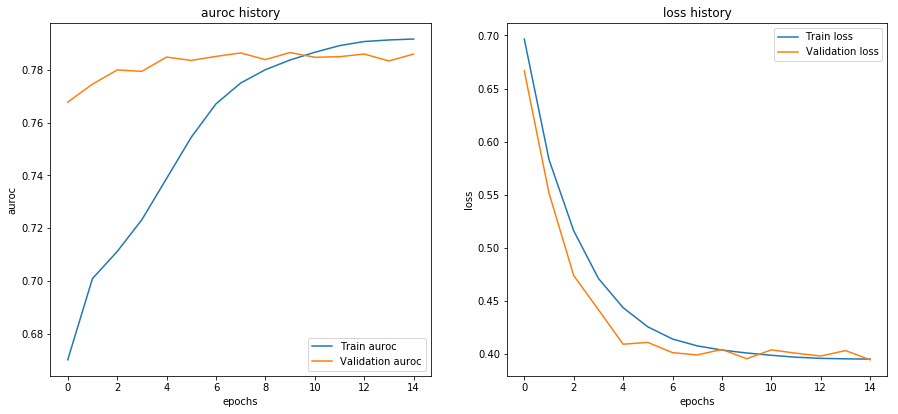

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 12us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 36s 262ms/step - loss: 0.6907 - auroc: 0.6753 - mAP: 0.3345 - val_loss: 0.5780 - val_auroc: 0.7662 - val_mAP: 0.4458
Epoch 2/100
139/139 [==============================] - 32s 229ms/step - loss: 0.5818 - auroc: 0.7022 - mAP: 0.3794 - val_loss: 0.4972 - val_auroc: 0.7728 - val_mAP: 0.4573
Epoch 3/100
139/139 [==============================] - 32s 232ms/step - loss: 0.5141 - auroc: 0.7123 - mAP: 0.3886 - val_loss: 0.4472 - val_auroc: 0.7740 - val_mAP: 0.4532
Epoch 4/100
139/139 [==============================] - 32s 228ms/step - loss: 0.4692 - auroc: 0.7243 - mAP: 0.3952 - val_loss: 0.4176 - val_auroc: 0.7774 - val_mAP: 0.4567
Epoch 5/100
103/139 [=====================>........] - ETA: 8s - loss: 0.4443 - auroc: 0.7383 - mAP: 0.4057

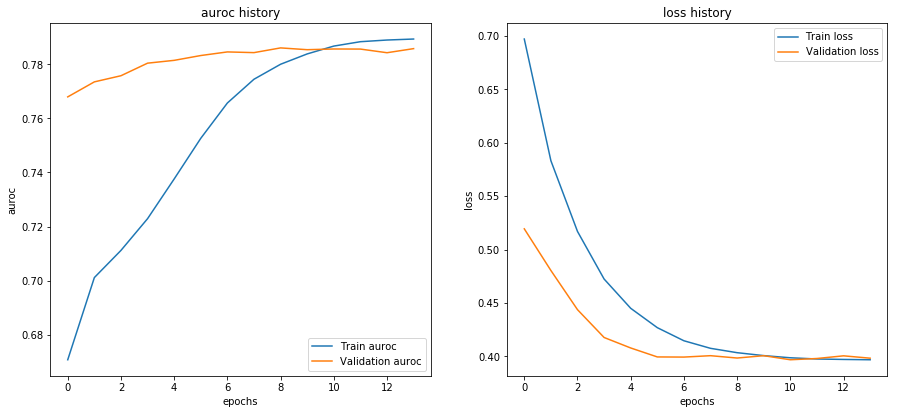

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 13us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 35s 255ms/step - loss: 0.6973 - auroc: 0.6712 - mAP: 0.3281 - val_loss: 0.5365 - val_auroc: 0.7653 - val_mAP: 0.4434
Epoch 2/100
139/139 [==============================] - 32s 231ms/step - loss: 0.5836 - auroc: 0.6999 - mAP: 0.3753 - val_loss: 0.4825 - val_auroc: 0.7702 - val_mAP: 0.4541
Epoch 3/100
139/139 [==============================] - 32s 234ms/step - loss: 0.3953 - auroc: 0.7914 - mAP: 0.4729 - val_loss: 0.4023 - val_auroc: 0.7811 - val_mAP: 0.4575

FOLD 10


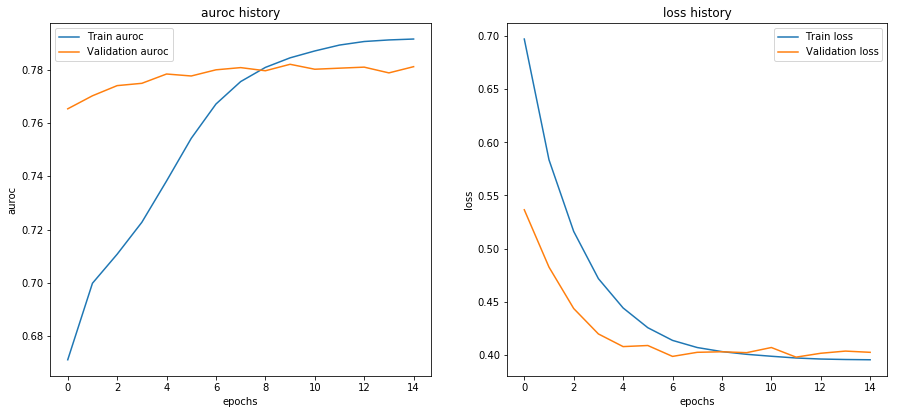

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 4s 11us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 36s 258ms/step - loss: 0.6954 - auroc: 0.6728 - mAP: 0.3304 - val_loss: 0.5512 - val_auroc: 0.7663 - val_mAP: 0.4475
Epoch 2/100
139/139 [==============================] - 32s 227ms/step - loss: 0.5826 - auroc: 0.7014 - mAP: 0.3762 - val_loss: 0.4879 - val_auroc: 0.7717 - val_mAP: 0.4583
Epoch 3/100
139/139 [==============================] - 31s 224ms/step - loss: 0.4093 - auroc: 0.7733 - mAP: 0.4429 - val_loss: 0.4020 - val_auroc: 0.7786 - val_mAP: 0.4585
Epoch 17/100
139/139 [==============================] - 31s 226ms/step - loss: 0.4092 - auroc: 0.7734 - mAP: 0.4430 - val_loss: 0.3975 - val_auroc: 0.7815 - val_mAP: 0.4636
Epoch 18/100
139/139 [==============================] - 31s 226ms/step - loss: 0.4090 - auroc: 0.7737 - mAP: 0.4434 - val_loss: 0.4061 - val_auroc: 0.7778 - val_mAP: 0.4563
Epoch 19/100
139/139 [==============================] - 32s 228ms/step - loss: 0.4078 - auroc: 0.7751 - mAP: 0.4458 - val_loss: 0.4017 - v

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 35s 254ms/step - loss: 0.7011 - auroc: 0.6673 - mAP: 0.3248 - val_loss: 0.7160 - val_auroc: 0.7703 - val_mAP: 0.4603
Epoch 2/100
139/139 [==============================] - 32s 232ms/step - loss: 0.5849 - auroc: 0.6985 - mAP: 0.3722 - val_loss: 0.5793 - val_auroc: 0.7735 - val_mAP: 0.4629
Epoch 3/100
139/139 [==============================] - 31s 226ms/step - loss: 0.5177 - auroc: 0.7095 - mAP: 0.3838 - val_loss: 0.4777 - val_auroc: 0.7808 - val_mAP: 0.4666
Epoch 4/100
139/139 [==============================] - 31s 227ms/step - loss: 0.3990 - auroc: 0.7866 - mAP: 0.4648 - val_loss: 0.4017 - val_auroc: 0.7871 - val_mAP: 0.4727
Epoch 17/100
139/139 [==============================] - 32s 233ms/step - loss: 0.3989 - auroc: 0.7867 - mAP: 0.4650 - val_loss: 0.4003 - val_auroc: 0.7868 - val_mAP: 0.4697

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 18/100
139/139 [==============================] - 32s 228ms/step - l

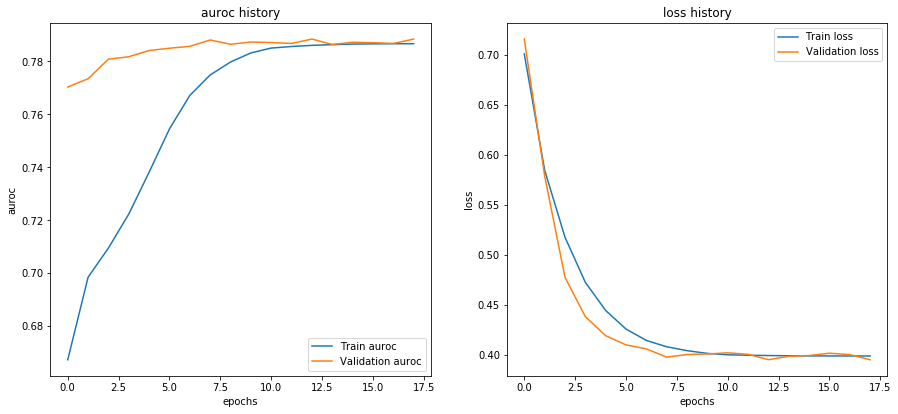

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 12us/step


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
139/139 [==============================] - 33s 235ms/step - loss: 0.3960 - auroc: 0.7906 - mAP: 0.4704 - val_loss: 0.3947 - val_auroc: 0.7840 - val_mAP: 0.4657

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 14/100
139/139 [==============================] - 32s 228ms/step - loss: 0.3949 - auroc: 0.7920 - mAP: 0.4723 - val_loss: 0.3981 - val_auroc: 0.7848 - val_mAP: 0.4678
Epoch 15/100
139/139 [==============================] - 33s 235ms/step - loss: 0.3945 - auroc: 0.7926 - mAP: 0.4731 - val_loss: 0.4078 - val_auroc: 0.7829 - val_mAP: 0.4607

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 16/100
139/139 [==============================] - 32s 233ms/step - loss: 0.4018 - auroc: 0.7826 - mAP: 0.4596 - val_loss: 0.4008 - val_auroc: 0.7863 - val_mAP: 0.4649
Epoch 12/100
139/139 [==============================] - 32s 228ms/step - loss: 0.4012 - auroc: 0.7835 - mAP: 0.4609 - val_loss: 0.3911 - val_auroc: 

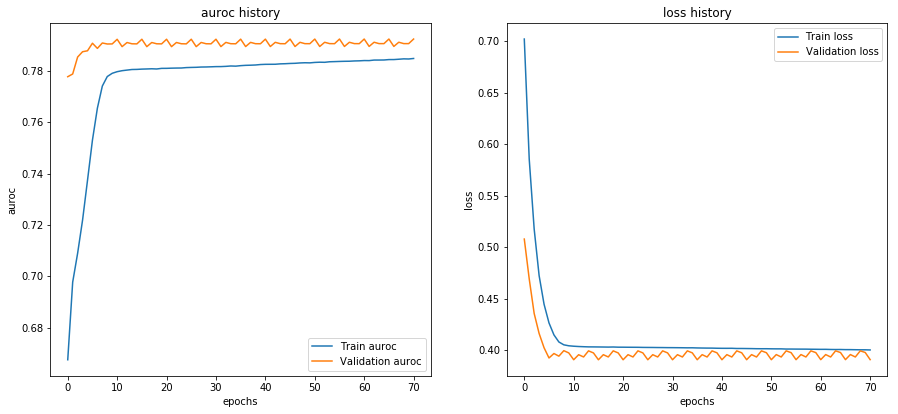

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


400000/400000 [==============================] - 5s 12us/step


In [20]:
# Setting the CV strategy
skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

# CV Iteration: we store best epochs, oof and cv testv prediciton
roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))
best_iteration = list()
cv_test_preds = np.zeros(len(Xt))

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    
    # Re-instantiating the model
    model = compile_model(tabular_dnn(**model_params), 
                          binary_crossentropy, 
                          [auroc, mAP], 
                          Adam(learning_rate=0.0001))
    
    # Creating the train and validation sets
    X_cv_ohe = X_ohe[train_idx].astype(np.float32)
    X_cv_cat = [X_cat[i][train_idx] for i in range(len(X_cat))]
    y_cv = y[train_idx]
    X_oof_ohe = X_ohe[test_idx].astype(np.float32)
    X_oof_cat = [X_cat[i][test_idx] for i in range(len(X_cat))]
    y_oof = y[test_idx]
    
    # Instantiating the train and validation generators
    train_batch = batch_generator(X_cv_ohe,
                                  X_cv_cat,
                                  y_cv,
                                  batch_size=BATCH_SIZE,
                                  random_state=SEED)
    
    val_batch = batch_generator(X_oof_ohe,
                                X_oof_cat,
                                y_oof,
                                batch_size=BATCH_SIZE,
                                random_state=SEED)
    
    train_steps = len(y_cv) // BATCH_SIZE 
    validation_steps = len(y_oof) // BATCH_SIZE
    
    # Training
    history = model.fit_generator(train_batch,
                                  validation_data=val_batch,
                                  epochs=MAX_EPOCHS,
                                  steps_per_epoch=train_steps,
                                  validation_steps=validation_steps,
                                  callbacks=[model_checkpoint, early_stopping, model_reduce_lr],
                                  #class_weight=[1.0, (np.sum(y_cv==0) / np.sum(y_cv==1))],
                                  verbose=1)
    
    # Reporting
    print("\nFOLD %i" % fold)
    plot_keras_history(history, measures=['auroc', 'loss'])
    
    # OOF prediction
    best_iteration.append(np.argmax(history.history['val_auroc']) + 1)
    
    model = load_model('best.model')
    
    preds = model.predict([X_oof_ohe] + X_oof_cat,
                          verbose=1,
                          batch_size=1024).flatten()

    oof[test_idx] = preds

    roc_auc.append(roc_auc_score(y_true=y_oof, y_score=preds))
    
    average_precision.append(average_precision_score(y_true=y_oof, y_score=preds))
    
    # CV test prediction
    cv_test_preds += model.predict([Xt_ohe] + Xt_cat,
                                   verbose=1,
                                   batch_size=1024).flatten() / FOLDS

In [21]:
# Storing results to disk
oof = pd.DataFrame({'id':id_train, 'dnn_oof': oof})
oof.to_csv("oof.csv", index=False)

submission = pd.read_csv("/kaggle/input/cat-in-the-dat-ii/sample_submission.csv")
submission.target = cv_test_preds
submission.to_csv("./dnn_cv_submission.csv", index=False)

In [22]:
# Reporting from training
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof.dnn_oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof.dnn_oof))

Average cv roc auc score 0.795 ± 0.006
Average cv roc average precision 0.476 ± 0.008
Roc auc score OOF 0.794
Average precision OOF 0.475


In [23]:
# We now train on all the examples, using a rule of thumb for the number of iterations
train_batch = batch_generator(X_ohe, X_cat, y,
                              batch_size=BATCH_SIZE,
                              random_state=SEED)

train_steps = len(y) // BATCH_SIZE

model = compile_model(tabular_dnn(**model_params), 
                      binary_crossentropy, 
                      [auroc, mAP], 
                      Adam(learning_rate=0.0001))

history = model.fit_generator(train_batch,
                              epochs=int(np.median(best_iteration)),
                              steps_per_epoch=train_steps,
                              #class_weight=[1.0, (np.sum(y==0) / np.sum(y==1))],
                              verbose=1)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/13
146/146 [==============================] - 41s 283ms/step - loss: 0.6937 - auroc: 0.6722 - mAP: 0.3310
Epoch 2/13
146/146 [==============================] - 38s 261ms/step - loss: 0.5774 - auroc: 0.7016 - mAP: 0.3764
Epoch 3/13
146/146 [==============================] - 38s 261ms/step - loss: 0.5100 - auroc: 0.7120 - mAP: 0.3859
Epoch 4/13
146/146 [==============================] - 37s 255ms/step - loss: 0.4661 - auroc: 0.7254 - mAP: 0.3942
Epoch 5/13
146/146 [==============================] - 38s 258ms/step - loss: 0.4388 - auroc: 0.7428 - mAP: 0.4083
Epoch 6/13
146/146 [==============================] - 37s 256ms/step - loss: 0.4212 - auroc: 0.7596 - mAP: 0.4247
Epoch 7/13
146/146 [==============================] - 37s 253ms/step - loss: 0.4116 - auroc: 0.7708 - mAP: 0.4385
Epoch 8/13
146/146 [==============================] - 38s 260ms/step - loss: 0.4063 - auroc: 0.7772 - mAP: 0.4489
Epoch 9/13
146/146 [==============================] - 37s 255ms/step - loss: 0.4029 - au

In [24]:
# Predicting and final submission
test_preds = model.predict([Xt_ohe] + Xt_cat,
                           verbose=1,
                           batch_size=1024).flatten()

submission = pd.read_csv("/kaggle/input/cat-in-the-dat-ii/sample_submission.csv")
submission.target = test_preds
submission.to_csv("./submission.csv", index=False)

400000/400000 [==============================] - 5s 13us/step


In [25]:
# Blend
submission.target = (submission.target + pd.read_csv("./dnn_cv_submission.csv").target) / 2
submission.to_csv("./blend_submission.csv", index=False)